# Compute the minimised free energy for a given correlation matrix
*Cyril Rommens, s12495719, masterproject MSc Physics and Astronomy: Computational Physics of Complex Systems*

**Content**
Script that takes as input the pruned correlation matrix, f.e. generated from a time series set, and gives as output:
- The subject ID
- The analytical max(S)
- The analytical min(U)
- The optimised min(F) for a range of temperatures (so a list of scalars)
- The probability distribution p for each optimised F (so a list of lists)

Note: if I want to include the pruning of the matrix, I have to give as input the original timeseries from which the correlation matrix and phase randomised can be generated, and then the pruned one consecutively.

In [15]:
# Import necessary libraries
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# Import external background functions
%run Week_18_functions.py
%run infotopo.py

In [285]:
# Import HCP data to test the script
path = glob.glob('Pruned_data_HCPAging\REST1\*.txt')

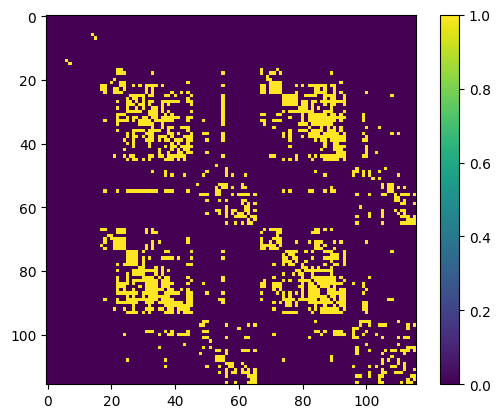

In [368]:
matrix = np.loadtxt('Cyril\prunned_matrix.txt')
matrix = matrix - np.eye(len(matrix),len(matrix))
plt.imshow(matrix)
plt.colorbar()
plt.show()

In [370]:
density = np.sum(matrix)/(len(matrix)**2)
print(f'The density of the pruned matrix is {density:.2f}')

The density of the pruned matrix is 0.11


In [ ]:
%time complete_f_generator('Cyril\prunned_matrix.txt', 3)

In [367]:
def complete_f_generator(file, max_dim):
    # Import datafile as matrix
    matrix = np.loadtxt(file)

    # Extract patient ID from filename
    identification_code = 'no HCA found'
    parts = file.split('_')
    for part in parts:
        if part.startswith("HCA"):
            identification_code = part[3:]
            break

    # Generate connection matrix and inverse
    clique_complex =  build_clique_complex(matrix, max_dim)
    matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

    # Generate maximum shannon entropy from uniform distribution
    n = len(inverse_connectivity_matrix)
    p_Smax = np.ones(n) / n
    max_entropy_value = shannon_entropy(p_Smax)

    # Generate minimum internal energy from analytical solution
    min_energy_probabilities = (np.inner(matrix,[1]*len(matrix)))/np.sum(matrix)
    min_energy_value = energy_function(min_energy_probabilities, inverse_connectivity_matrix)

    # Generate minimum free energy by custom optimisation
    f_per_T = []
    p_per_T = []
    temperature_list = [0.5] #One temperature for now, to look at a range use here: np.arange(0, 1, 1)

    for temperature in temperature_list:
        free_energy_history, f_probabilities = free_energy_minimisation(clique_complex, inverse_connectivity_matrix, 1000, temperature)
        f_per_T.append(free_energy_history[-1])
        p_per_T.append(f_probabilities)

    return [identification_code, max_entropy_value, min_energy_value, f_per_T, p_per_T, temperature_list]

In [315]:
# Create an empty DataFrame with specified columns
df = pd.DataFrame(columns=['identification_code', 'max_entropy', 'min_energy', 'F_per_T', 'p_per_T', 'temperatures'])
max_clique_size = 3

for file in path[:5]:
    F = complete_f_generator(file, 3)
    # Append the list as a new row to the DataFrame
    df.loc[len(df)] = F

In [316]:
df

,identification_code,max_entropy,min_energy,F_per_T,p_per_T,temperatures
0,6002236,7.727920,0.000445,[-3.605230048361686],"[[0.0038152903066105766, 0.008750248076188152,...",[0.5]
1,6010538,7.781360,0.000334,[-3.618612886073435],"[[0.008451894160299072, 0.00024010290111203795...",[0.5]
2,6018857,7.768184,0.000401,[-3.6057797466705055],"[[0.009318305200515948, 0.006174028332138782, ...",[0.5]
3,6030645,7.714246,0.000512,[-3.6164519435879936],"[[0.0050151980903812236, 0.009482490728001178,...",[0.5]
4,6047359,7.727920,0.000438,[-3.6123397956186487],"[[0.002031845934579866, 0.0049611475408255865,...",[0.5]


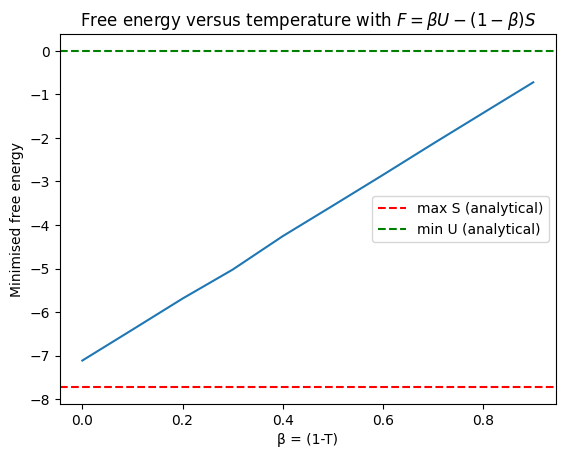

In [288]:
plt.plot(F[5], F[3])
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.axhline(y=-F[1], color='r', linestyle='--', label='max S (analytical)')
plt.axhline(y=F[2], color='g', linestyle='--', label='min U (analytical)')
plt.legend() 
plt.show()

# Pre-process the data to prepare as input for Pierre's code

**First explore the synchronous static case**

In [235]:
df = pd.read_csv('Cyril\\100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt', sep='\t', header=None)

In [236]:
# Initialize an empty DataFrame to hold discretized values
discretized_time_series = pd.DataFrame()

# Iterate over each column of 'df'
for col in df.columns:
    data = df[col].tolist()
    hist, bin_edges = np.histogram(data, bins=16)
    bin_numbers = np.digitize(data, bin_edges[:-1])
    
    # Create a DataFrame with the current column's discretized values
    col_df = pd.DataFrame({col: bin_numbers}, index=df.index)
    
    # Concatenate the new DataFrame along the columns axis
    discretized_time_series = pd.concat([discretized_time_series, col_df], axis=1)

In [237]:
discretized_time_series

,0,1,2,3,4,5,6,7,8,9,...,2390,2391,2392,2393,2394,2395,2396,2397,2398,2399
0,8,7,8,4,6,5,8,8,12,11,...,7,7,5,5,8,12,8,5,2,3
1,7,9,7,10,7,6,10,11,12,12,...,5,6,6,5,11,11,7,6,5,5
2,7,6,8,7,8,6,8,10,11,12,...,7,7,4,6,8,13,8,10,4,3
3,9,9,7,7,9,8,9,10,11,11,...,7,7,6,6,7,11,8,7,4,4
4,7,4,4,1,7,4,7,7,11,12,...,5,6,7,7,12,7,6,6,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,5,4,2,2,6,6,6,7,11,11,...,6,7,6,5,5,8,6,8,8,3
112,9,7,3,1,4,5,6,7,11,10,...,7,8,8,5,5,11,11,8,7,5
113,12,8,3,6,6,7,8,6,7,7,...,4,4,3,3,8,13,13,9,13,9
114,8,5,6,4,7,5,5,9,12,9,...,7,3,2,4,7,7,9,8,5,4


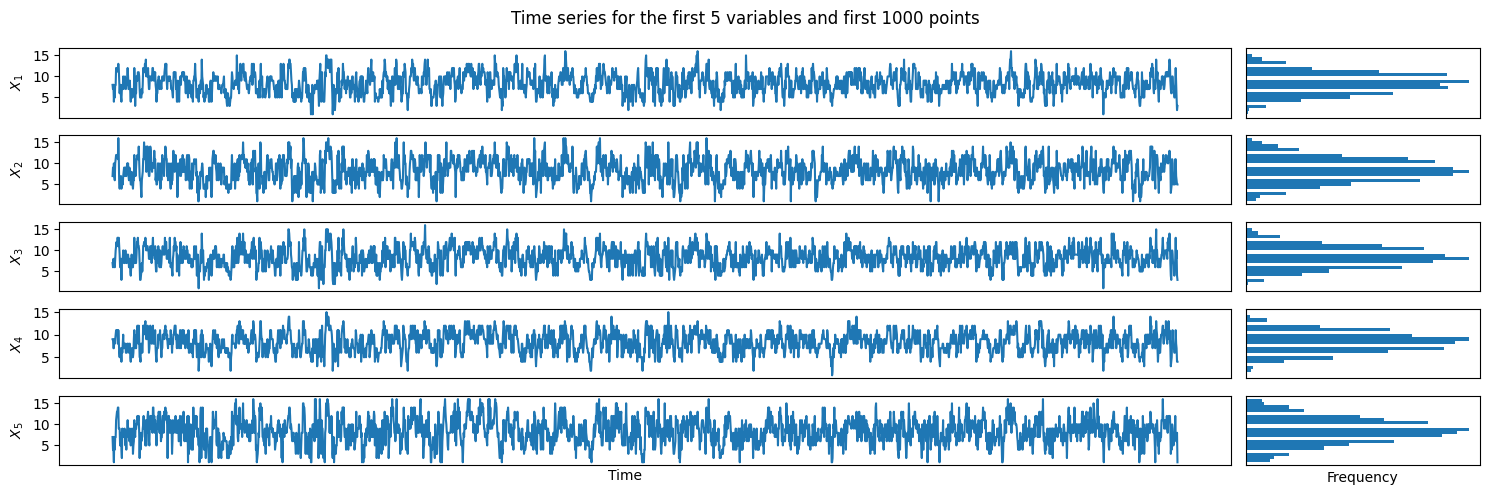

In [238]:
# Example DataFrame creation for demonstration
df = discretized_time_series.T

# Determine the number of subplots to create
num_subplots = min(len(df.columns), 5)

# Plotting
fig, axes = plt.subplots(nrows=num_subplots, ncols=2, figsize=(15, 5), 
                         gridspec_kw={'width_ratios': [5, 1]})  # Adjust width ratios

# Plot each variable on its subplot and histogram next to it
for i, col in enumerate(df.columns[:num_subplots]):  # Limit to num_subplots
    # Plot time series
    axes[i, 0].plot(df.index, df[col])
    axes[i, 0].set_ylabel(f'$X_{col+1}$')
    axes[i, 0].set_xticks([])  # Remove x-axis ticks
    
    # Plot histogram
    axes[i, 1].hist(df[col], bins=20, orientation='horizontal')
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])

# Adjust layout
plt.suptitle('Time series for the first 5 variables and first 1000 points')
plt.xlabel('Frequency')
fig.text(0.42, 0.04, 'Time', ha='center')
plt.tight_layout()

# Display plot
plt.show()

In [188]:
np.savetxt('discretized_time_series.txt',discretized_time_series.T)

In [189]:
discretized_time_series = pd.read_csv('discretized_time_series.txt', sep=' ', header=None)

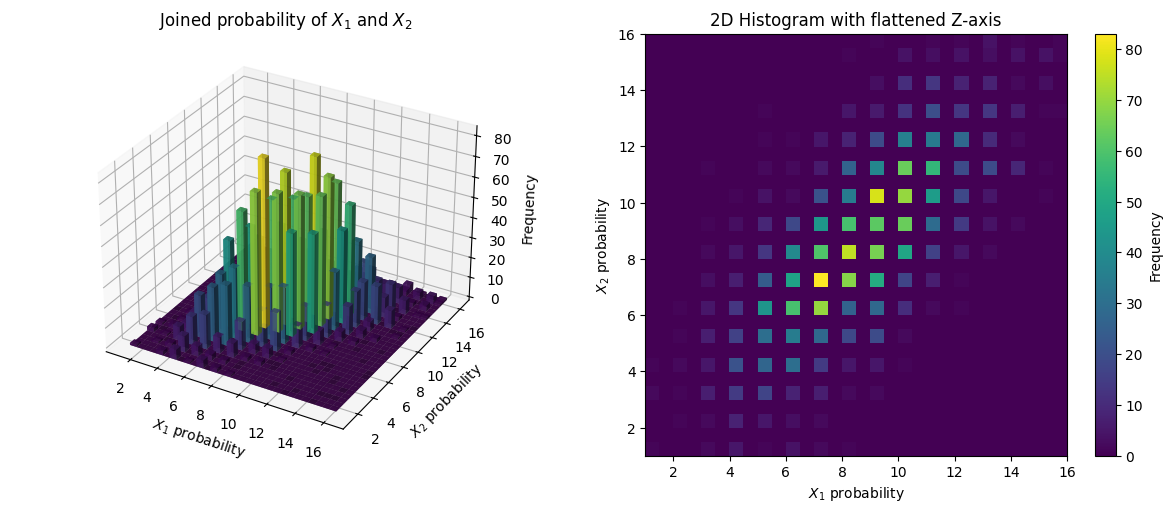

In [190]:
# Example for two correlations
x = discretized_time_series.iloc[:, 0].tolist()
y = discretized_time_series.iloc[:, 1].tolist()

# Create figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot 3D histogram
ax1 = fig.add_subplot(121, projection='3d')
hist, xedges, yedges = np.histogram2d(x, y, bins=30)
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()
ax1.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=plt.cm.viridis(dz / dz.max()), alpha=0.8)
ax1.set_xlabel('$X_1$ probability')
ax1.set_ylabel('$X_2$ probability')
ax1.set_zlabel('Frequency')
ax1.set_title('Joined probability of $X_1$ and $X_2$')

# Plot 2D histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=30)
img = ax[1].imshow(hist.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='viridis')
ax[1].set_xlabel('$X_1$ probability')
ax[1].set_ylabel('$X_2$ probability')
ax[1].set_title('2D Histogram with flattened Z-axis')

# Figure specs
plt.colorbar(img, ax=ax[1], label='Frequency')
ax[0].axis('off')
plt.tight_layout()
plt.show()

**Redo this for fixed bin_edges**

In [205]:
df = pd.read_csv('Cyril\\100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt', sep='\t', header=None)

In [206]:
# Initialize an empty DataFrame to hold discretized values
discretized_time_series = pd.DataFrame()
max_BOLD = df.max().max()
min_BOLD = df.min().min()
desired_number_of_bins = 16
stepsize = (max_BOLD-min_BOLD)/desired_number_of_bins
bin_edges = np.arange(min_BOLD, max_BOLD, stepsize)

# Iterate over each column of 'df'
for col in df.columns:
    data = df[col].tolist()
    bin_numbers = np.digitize(data, bin_edges)
    
    # Create a DataFrame with the current column's discretized values
    col_df = pd.DataFrame({col: bin_numbers}, index=df.index)
    
    # Concatenate the new DataFrame along the columns axis
    discretized_time_series = pd.concat([discretized_time_series, col_df], axis=1)

In [207]:
discretized_time_series

,0,1,2,3,4,5,6,7,8,9,...,2390,2391,2392,2393,2394,2395,2396,2397,2398,2399
0,8,7,8,7,7,7,7,7,8,8,...,8,8,8,8,8,8,8,7,7,8
1,7,8,8,8,8,8,8,8,8,8,...,7,8,8,8,9,8,8,7,8,8
2,8,7,8,8,8,8,8,8,8,8,...,8,8,7,8,8,8,8,8,8,8
3,8,8,8,8,8,8,8,8,7,8,...,8,8,8,8,8,8,8,8,8,8
4,7,6,7,6,7,7,7,7,7,8,...,7,8,8,8,9,7,7,7,9,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,7,6,6,6,7,7,7,7,7,8,...,8,8,8,8,7,7,7,8,9,8
112,8,7,6,6,6,7,7,7,8,7,...,8,8,9,7,7,8,8,8,8,8
113,9,8,6,7,7,8,8,6,6,6,...,7,7,7,7,8,8,9,8,10,9
114,8,7,7,7,7,7,6,7,8,7,...,8,6,7,7,8,7,8,8,8,8


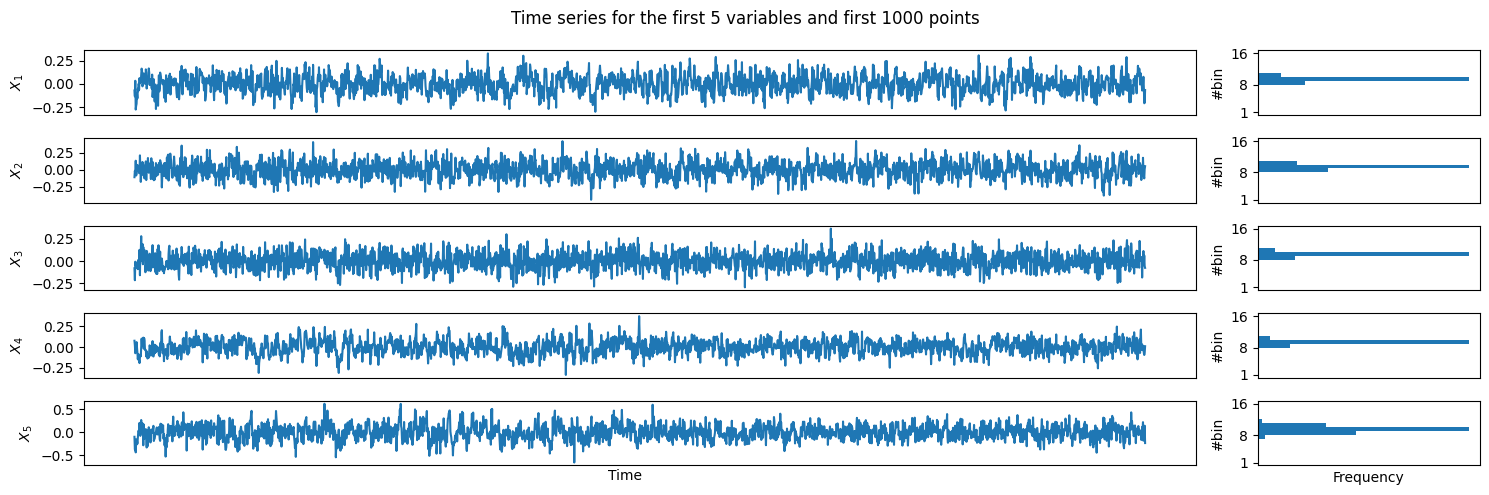

In [230]:
# Example DataFrame creation for demonstration
df = df.T

# Determine the number of subplots to create
num_subplots = min(len(df.columns), 5)

# Plotting
fig, axes = plt.subplots(nrows=num_subplots, ncols=2, figsize=(15, 5), 
                         gridspec_kw={'width_ratios': [5, 1]})  # Adjust width ratios

# Plot each variable on its subplot and histogram next to it
for i, col in enumerate(df.columns[:num_subplots]):  # Limit to num_subplots
    # Plot time series
    axes[i, 0].plot(df.index, df[col])
    axes[i, 0].set_ylabel(f'$X_{col+1}$')
    axes[i, 0].set_xticks([])  # Remove x-axis ticks
    
    # Plot histogram
    axes[i, 1].hist(discretized_time_series.T[col], bins=np.arange(0, 16, 1), orientation='horizontal')
    axes[i, 1].set_ylabel('#bin')
    axes[i, 1].set_yticks([0,7,15])
    axes[i, 1].set_yticklabels(['1','8','16'])
    axes[i, 1].set_xticks([])
    #axes[i, 1].set_yticks([])

# Adjust layout
plt.suptitle('Time series for the first 5 variables and first 1000 points')
plt.xlabel('Frequency')
fig.text(0.42, 0.04, 'Time', ha='center')
plt.tight_layout()

# Display plot
plt.show()

In [195]:
np.savetxt('discretized_time_series.txt',discretized_time_series.T)

In [196]:
discretized_time_series = pd.read_csv('discretized_time_series.txt', sep=' ', header=None)

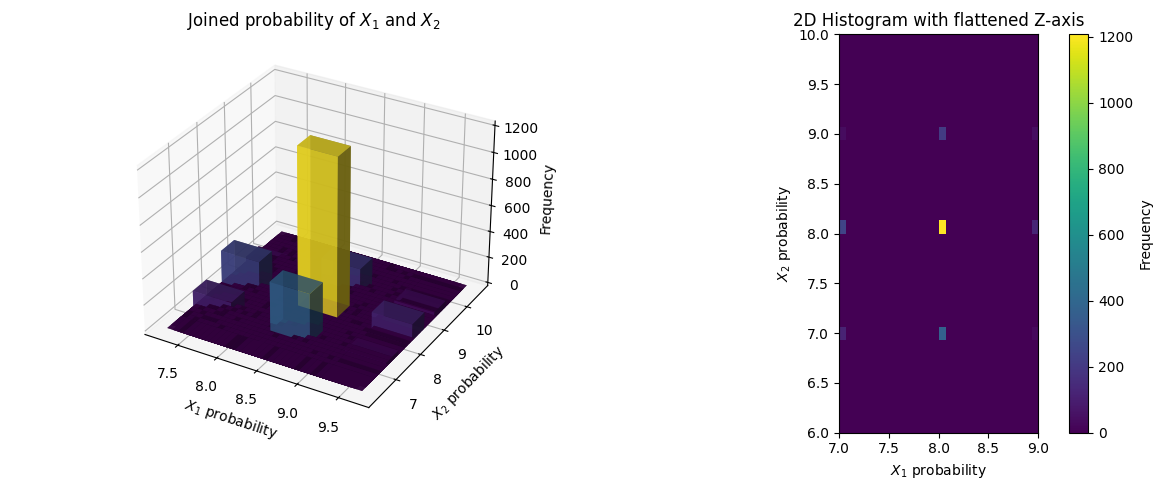

In [197]:
# Example for two correlations
x = discretized_time_series.iloc[:, 0].tolist()
y = discretized_time_series.iloc[:, 1].tolist()

# Create figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot 3D histogram
ax1 = fig.add_subplot(121, projection='3d')
hist, xedges, yedges = np.histogram2d(x, y, bins=30)
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()
ax1.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=plt.cm.viridis(dz / dz.max()), alpha=0.8)
ax1.set_xlabel('$X_1$ probability')
ax1.set_ylabel('$X_2$ probability')
ax1.set_zlabel('Frequency')
ax1.set_title('Joined probability of $X_1$ and $X_2$')

# Plot 2D histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=30)
img = ax[1].imshow(hist.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='viridis')
ax[1].set_xlabel('$X_1$ probability')
ax[1].set_ylabel('$X_2$ probability')
ax[1].set_title('2D Histogram with flattened Z-axis')

# Figure specs
plt.colorbar(img, ax=ax[1], label='Frequency')
ax[0].axis('off')
plt.tight_layout()
plt.show()


**Implement moving window to explore the time dynamics**

In [210]:
df = pd.read_csv('Cyril\\100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt', sep='\t', header=None)

In [227]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image  # Import Image module from Pillow

# Example data
data1 = df.iloc[0].tolist()[:1000]
data2 = df.iloc[1].tolist()[:1000]
window_size = 100
frames = []

for base in np.arange(0, len(data1) - window_size - window_size, 10):
    front_limit1 = base
    back_limit1 = base+window_size
    front_limit2 = base+window_size
    back_limit2 = base+window_size+window_size
    # Perform random walk
    walk1 = data1[front_limit1:back_limit1]
    walk2 = data2[front_limit2:back_limit2]

    # Create a figure with two subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [5, 1]})

    # Plot time series 1
    axs[0, 0].plot(range(len(data1)), data1)
    axs[0, 0].axvline(x=front_limit1, color='red', linestyle='--')
    axs[0, 0].axvline(x=back_limit1, color='red', linestyle='--')
    axs[0, 0].fill_between(range(front_limit1, back_limit1), min(data1), max(data1), color='salmon', alpha=0.3)
    axs[0, 0].set_ylabel('$X_1$')

    # Plot histogram 1
    hist1, bin_edges1 = np.histogram(walk1, bins=16)
    axs[0, 1].hist(walk1, bins=16, color='salmon', edgecolor='black', orientation='horizontal')
    axs[0, 1].set_xticks([])
    #axs[0, 1].set_yticks([])

    # Plot time series 2
    axs[1, 0].plot(range(len(data2)), data2)
    axs[1, 0].axvline(x=front_limit2, color='red', linestyle='--')
    axs[1, 0].axvline(x=back_limit2, color='red', linestyle='--')
    axs[1, 0].fill_between(range(front_limit2, back_limit2), min(data2), max(data2), color='salmon', alpha=0.3)
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('$X_2$')

    # Plot histogram 2
    hist2, bin_edges2 = np.histogram(walk2, bins=16)
    axs[1, 1].hist(walk2, bins=16, color='salmon', edgecolor='black', orientation='horizontal')
    axs[1, 1].set_xlabel('Frequency')
    axs[1, 1].set_xticks([])
    #axs[1, 1].set_yticks([])

    # Adjust layout
    plt.tight_layout()

    # Convert figure to PIL Image
    fig.canvas.draw()
    img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

    # Append the current frame to the list of frames
    frames.append(img)

    # Close the figure to avoid memory leaks
    plt.close(fig)

# Save frames as GIF
frames[0].save('combined_timeseries_sliding.gif', save_all=True, append_images=frames[1:], optimize=False, duration=200, loop=0)

C:\Users\cyril\AppData\Local\Temp\ipykernel_10484\1870820374.py:56: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())


**Generate time-slided list for input Pierre's code**

In [198]:
df = pd.read_csv('Cyril\\100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt', sep='\t', header=None)

In [199]:
# Initialize an empty DataFrame to hold discretized values
discretized_time_series = pd.DataFrame()

# Iterate over each column of 'df'
for col in df.columns:
    data = df[col].tolist()
    hist, bin_edges = np.histogram(data, bins=16)
    bin_numbers = np.digitize(data, bin_edges[:-1])
    
    # Create a DataFrame with the current column's discretized values
    col_df = pd.DataFrame({col: bin_numbers}, index=df.index)
    
    # Concatenate the new DataFrame along the columns axis
    discretized_time_series = pd.concat([discretized_time_series, col_df], axis=1)

In [200]:
discretized_time_series

,0,1,2,3,4,5,6,7,8,9,...,2390,2391,2392,2393,2394,2395,2396,2397,2398,2399
0,8,7,8,4,6,5,8,8,12,11,...,7,7,5,5,8,12,8,5,2,3
1,7,9,7,10,7,6,10,11,12,12,...,5,6,6,5,11,11,7,6,5,5
2,7,6,8,7,8,6,8,10,11,12,...,7,7,4,6,8,13,8,10,4,3
3,9,9,7,7,9,8,9,10,11,11,...,7,7,6,6,7,11,8,7,4,4
4,7,4,4,1,7,4,7,7,11,12,...,5,6,7,7,12,7,6,6,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,5,4,2,2,6,6,6,7,11,11,...,6,7,6,5,5,8,6,8,8,3
112,9,7,3,1,4,5,6,7,11,10,...,7,8,8,5,5,11,11,8,7,5
113,12,8,3,6,6,7,8,6,7,7,...,4,4,3,3,8,13,13,9,13,9
114,8,5,6,4,7,5,5,9,12,9,...,7,3,2,4,7,7,9,8,5,4


In [201]:
%run infotopo.py

In [202]:
dataset = np.array(discretized_time_series).T
print(dataset.shape)

(2400, 116)


In [203]:
Nentropie = information_topo.simplicial_entropies_decomposition(dataset) 
Ninfomut = information_topo.simplicial_infomut_decomposition(Nentropie)

Percent of tuples processed : 0


In [204]:
print(len(Ninfomut))
print(Nentropie)

1023
{(10,): 2.534281317542283, (9,): 2.4108367556329444, (8,): 2.405381366144067, (7,): 2.35329863500843, (6,): 2.5067650793641, (5,): 2.6738854263025456, (4,): 2.397526103294659, (3,): 2.348555909745638, (2,): 2.557091168685431, (1,): 2.363718950921982, (9, 10): 4.490393831149589, (8, 10): 4.6697933856996885, (7, 10): 4.539007972342997, (6, 10): 4.745446605910907, (5, 10): 4.946623800625369, (4, 10): 4.5513123853915385, (3, 10): 4.478648256256911, (2, 10): 4.656796595396443, (1, 10): 4.468428980164925, (8, 9): 4.462249324360916, (7, 9): 4.341970412551481, (6, 9): 4.530199803203245, (5, 9): 4.760051737576052, (4, 9): 4.282464107428641, (3, 9): 4.206794587886422, (2, 9): 4.486072630976146, (1, 9): 4.080114623950176, (7, 8): 4.282387140919981, (6, 8): 4.610890371783711, (5, 8): 4.7227885418371045, (4, 8): 4.305432076328162, (3, 8): 4.3519479841867605, (2, 8): 4.659053567460374, (1, 8): 4.401092003870232, (6, 7): 4.470582733811868, (5, 7): 4.655439600848697, (4, 7): 4.167454508336277, (3

In [61]:
print(Ninfomut)

{(10,): 2.534281317542283, (9,): 2.4108367556329444, (8,): 2.405381366144067, (7,): 2.35329863500843, (6,): 2.5067650793641, (5,): 2.6738854263025456, (4,): 2.397526103294659, (3,): 2.348555909745638, (2,): 2.557091168685431, (1,): 2.363718950921982, (9, 10): 0.4547242420256383, (8, 10): 0.2698692979866619, (7, 10): 0.3485719802077156, (6, 10): 0.2955997909954764, (5, 10): 0.26154294321945937, (4, 10): 0.38049503544540375, (3, 10): 0.4041889710310098, (2, 10): 0.4345758908312707, (1, 10): 0.429571288299341, (8, 9): 0.353968797416095, (7, 9): 0.42216497808989395, (6, 9): 0.3874020317937994, (5, 9): 0.32467044435943837, (4, 9): 0.5258987514989624, (3, 9): 0.5525980774921608, (2, 9): 0.48185529334223, (1, 9): 0.69444108260475, (7, 8): 0.4762928602325154, (6, 8): 0.3012560737244563, (5, 8): 0.35647825060950744, (4, 8): 0.4974753931105633, (3, 8): 0.40198929170294395, (2, 8): 0.3034189673691241, (1, 8): 0.3680083131958165, (6, 7): 0.38948098056066094, (5, 7): 0.3717444604622786, (4, 7): 0.5

In [49]:
# Define the dictionary
dictionary = Ninfomut

# Extract keys and values
keys = list(dictionary.keys())
values = list(dictionary.values())

# Print the lists of keys and values
print("List of Keys:", len(keys))
print("List of Values:", values)

List of Keys: 1023
List of Values: [2.534281317542283, 2.4108367556329444, 2.405381366144067, 2.35329863500843, 2.5067650793641, 2.6738854263025456, 2.397526103294659, 2.348555909745638, 2.557091168685431, 2.363718950921982, 0.4547242420256383, 0.2698692979866619, 0.3485719802077156, 0.2955997909954764, 0.26154294321945937, 0.38049503544540375, 0.4041889710310098, 0.4345758908312707, 0.429571288299341, 0.353968797416095, 0.42216497808989395, 0.3874020317937994, 0.32467044435943837, 0.5258987514989624, 0.5525980774921608, 0.48185529334223, 0.69444108260475, 0.4762928602325154, 0.3012560737244563, 0.35647825060950744, 0.4974753931105633, 0.40198929170294395, 0.3034189673691241, 0.3680083131958165, 0.38948098056066094, 0.3717444604622786, 0.5833702299668122, 0.4637432822541534, 0.37617851317752127, 0.42078324224439445, 0.24088140683189518, 0.4458023662164994, 0.4066135048460868, 0.33735036712461497, 0.3562666956742122, 0.37169131179885806, 0.3073756161348804, 0.27403897395205146, 0.316005

In [44]:
import math

# Compute combination
n = 116  # Total number of items
k = 10  # Number of items to choose
result = math.comb(n, k)

print("Number of combinations:", result)

Number of combinations: 81572506886508


In [50]:
2**10

1024